In [1]:
%run setup.ipynb

In [37]:
sns.set_style('white')
sns.set_style('ticks')

In [180]:
def plot_signal(pop, chromosome, ax=None,  
                markersize=.5, filter_size=20, filter_t=2, stat=None, label=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 1), facecolor='w')
        sns.despine(ax=ax, offset=3)
        
    # load data
    windows, gwindows, h1, h12, h123, h2_h1 = load_h12_gwss(pop, chromosome)
    x = windows.mean(axis=1) / 1e6

    # filter
    if filter_size:
        h1 = hampel_filter(h1, size=filter_size, t=filter_t)
        h12 = hampel_filter(h12, size=filter_size, t=filter_t)
        h123 = hampel_filter(h123, size=filter_size, t=filter_t)

    # plot data
    if stat is None:
        palette = sns.color_palette("Blues_d", 3)[::-1]
        ax.plot(x, h123, linestyle=' ', marker='o', color=palette[0], markersize=markersize, label='H123')
        ax.plot(x, h12, linestyle=' ', marker='o', color=palette[1], markersize=markersize, label='H12')
        ax.plot(x, h1, linestyle=' ', marker='o', color=palette[2], markersize=markersize, label='H1')
    else:
        y = {'H1': h1, 'H12': h12, 'H123': h123}[stat]
        color = sns.color_palette()[0]
        ax.plot(x, y, linestyle=' ', marker='o', color=color, markersize=markersize, label=stat)
        
    # tidy plot
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xlim(0, chromosome_plen[chromosome] / 1e6)
#     ax.set_yticks([0, 1])
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.set_ylim(0, 1)

    if label:
        pop_label = pop_defs[pop]["label"]
        annotation = (
            pop_label
            .replace("An. gambiae", "$An. gambiae$")
            .replace("An. coluzzii", "$An. coluzzii$")
        )
        ax.annotate(annotation, xy=(0, 1), xytext=(2, 0), textcoords='offset points', fontsize=8, 
                    va='top', ha='left')

    

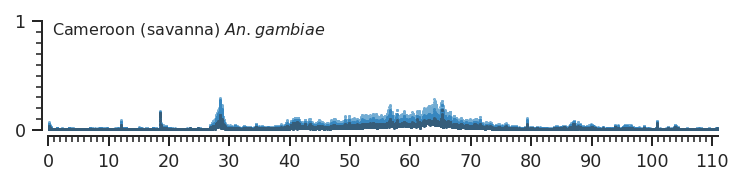

In [181]:
plot_signal('cm_sav_gam', '2', filter_size=None, label=True)

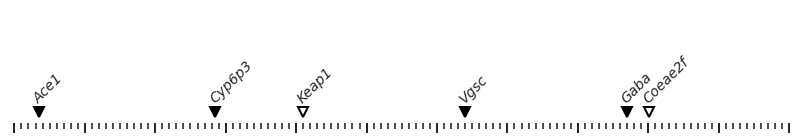

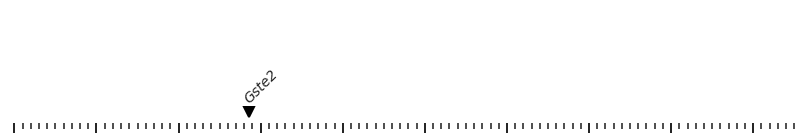

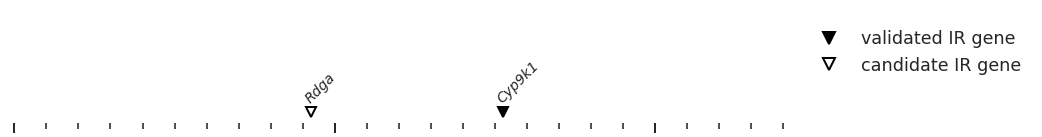

In [182]:
def plot_loci(chromosome, ax=None, legend=False, y=.1, fontsize=7):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 1), facecolor='w')
        sns.despine(left=True, bottom=True)
#     guide_loci(chromosome, ax=ax, ymax=.3)
    for gene in validated_ir_genes:
        if gene.chromosome == chromosome:
            x = (gene.chromosome_start + gene.chromosome_end) / 2e6
            ax.plot([x], [y], marker='v', linestyle=' ', color='k')
            ax.annotate(gene['Name'], xy=(x, y), xytext=(-4, 3), textcoords='offset points', 
                        fontstyle='italic', ha='left', va='bottom', fontsize=fontsize, rotation=45)
    for gene in candidate_ir_genes:
        if gene.chromosome == chromosome:
            x = (gene.chromosome_start + gene.chromosome_end) / 2e6
            ax.plot([x], [y], marker='v', linestyle=' ', color='k', mfc='none')
            ax.annotate(gene['Name'], xy=(x, y), xytext=(-4, 3), textcoords='offset points', 
                        fontstyle='italic', ha='left', va='bottom', fontsize=fontsize, rotation=45)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, chromosome_plen[chromosome]/1e6)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    if legend:
        from matplotlib.lines import Line2D
        validated_gene_marker = Line2D([], [], linestyle=' ', marker='v', color='k', 
                                       label='validated IR gene', markersize=6)
        candidate_gene_marker = Line2D([], [], linestyle=' ', marker='v', mfc='none', 
                                       mec='k', label='candidate IR gene', markersize=6)
        ax.legend(handles=[validated_gene_marker, candidate_gene_marker], bbox_to_anchor=(1, 1), 
                  loc='upper left', facecolor='w', edgecolor='w')
    
    
plot_loci('2')
plot_loci('3')
plot_loci('X', legend=True)

In [183]:
def fig_h12(pops, markersize=.5, figw=10, loci_figh=.7, pop_figh=1, savefig_dpi=150, stat=None):
    
    figsize = figw, loci_figh + pop_figh * len(pops) + .5
    fig = plt.figure(figsize=figsize, facecolor='w')
    width_ratios = [chromosome_plen[c] for c in chromosomes]
    gs = fig.add_gridspec(ncols=3, nrows=1 + len(pops), 
                          width_ratios=width_ratios, 
                          height_ratios=[loci_figh] + [pop_figh] * len(pops))
    
    # Loci
    
    ax = fig.add_subplot(gs[0, 0])
    sns.despine(ax=ax, offset=1, left=True)
    plot_loci(chromosome='2', ax=ax)
    ax.set_title('Chromosome 2')
    
    ax = fig.add_subplot(gs[0, 1])
    sns.despine(ax=ax, offset=1, left=True)
    plot_loci(chromosome='3', ax=ax)
    ax.set_title('Chromosome 3')
    
    ax = fig.add_subplot(gs[0, 2])
    sns.despine(ax=ax, offset=1, left=True)
    plot_loci(chromosome='X', ax=ax, legend=False)
    ax.set_title('Chromosome X')
    
    # H12
    
    for i, pop in enumerate(pops):
        
        ax = fig.add_subplot(gs[i+1, 0])
        sns.despine(ax=ax, offset=3)
        plot_signal(pop, chromosome='2', ax=ax, markersize=markersize, stat=stat,
                    label=True)
        if i < len(pops) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(f'Position (Mbp)')

        ax = fig.add_subplot(gs[i+1, 1])
        sns.despine(ax=ax, offset=3, left=True)
        ax.yaxis.set_tick_params(length=0, which='both')
        plot_signal(pop, chromosome='3', ax=ax, markersize=markersize, stat=stat)
        if i < len(pops) - 1:
            ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='y', length=0)

        ax = fig.add_subplot(gs[i+1, 2])
        sns.despine(ax=ax, offset=3, left=True)
        ax.yaxis.set_tick_params(length=0, which='both')
        plot_signal(pop, chromosome='X', ax=ax, markersize=markersize, stat=stat)
        if i < len(pops) - 1:
            ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='y', length=0)
    
    fig.tight_layout()
    

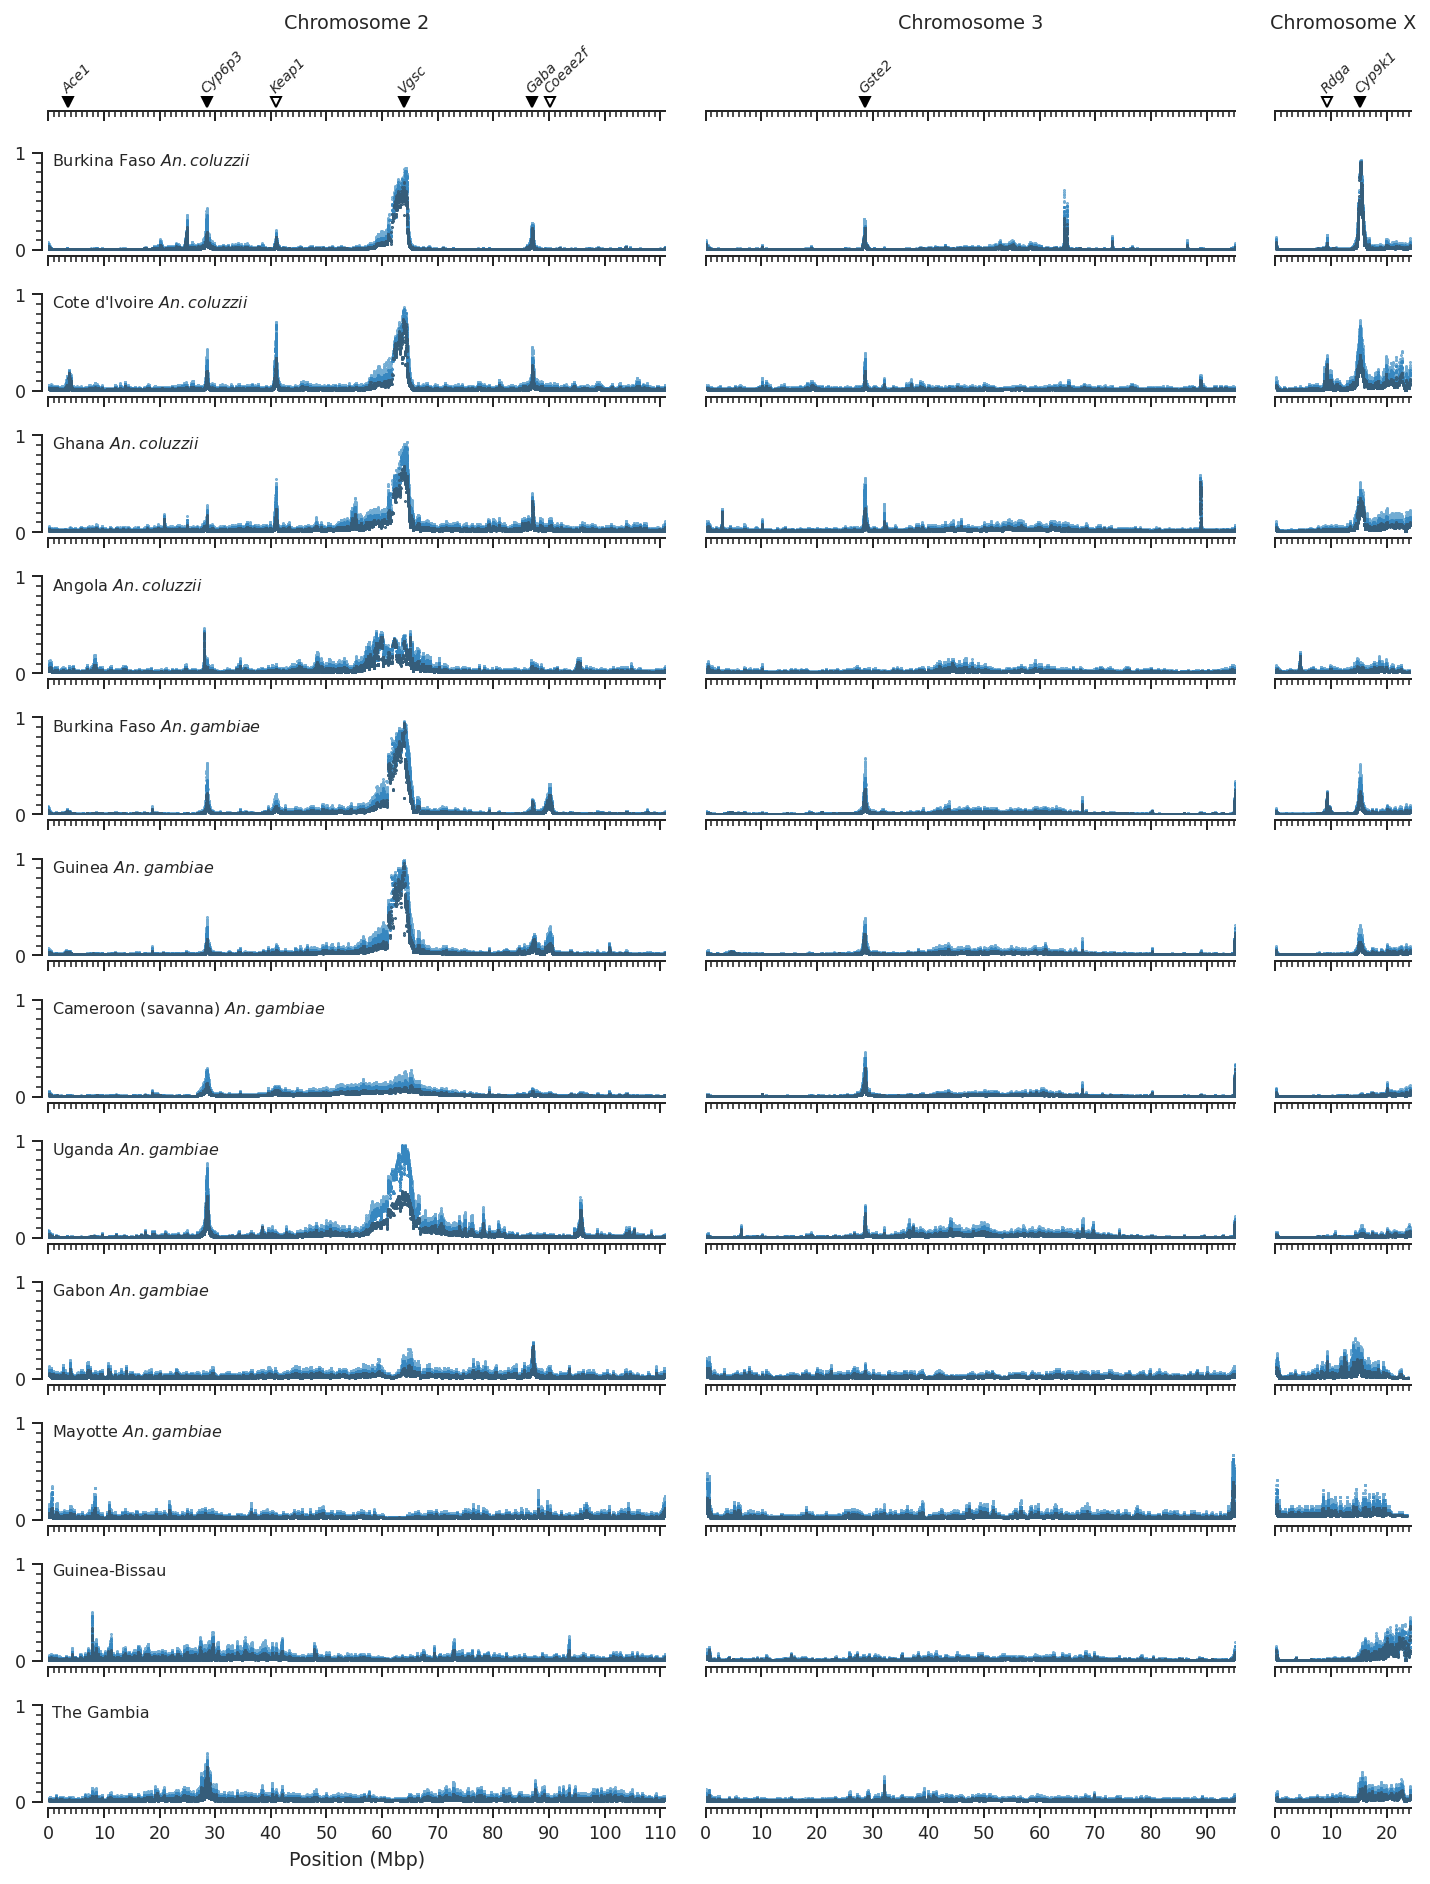

In [184]:
fig_h12(
    pops=[
        'bf_col',
        'ci_col',
        'gh_col',
        'ao_col',
        'bf_gam', 
        'gn_gam', 
#         'gh_gam',  # small sample size 
        'cm_sav_gam',
        'ug_gam', 
        'ga_gam',
#         'gq_gam',  # small sample size
        'fr_gam',
        'gw',
        'gm'
    ]
)

In [168]:
df_samples = pd.read_csv(here() / 'data/external/ag1000g/phase2/AR1/samples/samples.meta.txt', 
                         sep='\t')

In [173]:
for pop in pop_defs:
    pop_query = (
        pop_defs[pop]['query']
        .replace('region', 'location')
        .replace('Gado-Badzere', 'Gado Badzere')
        .replace('Zembe-Borongo', 'Zembe Borongo')
    )
    print(pop, len(df_samples.query(pop_query)))

ao_col 78
bf_col 75
bf_gam 92
ci_col 71
cm_sav_gam 96
fr_gam 24
ga_gam 69
gh_col 55
gh_gam 12
gm 65
gn_gam 40
gq_gam 9
gw 91
ke 48
ug_gam 112
